# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [15]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Agora vamos importar as bases de dados

Para isso, vamos criar um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número correspondente daquele mês.

Para cada arquivo da base de dados a gente vai importar o arquivo e criar uma coluna na base de dados com o mês e o ano de cada informação

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

# Usando pd.concat ao invés de append
dataframes = []

for arquivo in caminho_bases.iterdir():
    mes = meses[arquivo.name[:3]]
    ano = arquivo.name[-8:]
    ano = int(ano.replace(".csv", ""))
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    dataframes.append(df)

base_airbnb = pd.concat(dataframes, ignore_index=True)

display(base_airbnb)

# ------------------ codigo auternativo

# caminho_bases = pathlib.Path('dataset')
           # # Usando o método glob para encontrar todos os arquivos CSV
# arquivos_csv = caminho_bases.glob('*.csv')
           # # Concatenando diretamente todos os arquivos CSV
# base_airbnb = pd.concat((pd.read_csv(arquivo) for arquivo in arquivos_csv), ignore_index=True)

# display(base_airbnb)



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3228167297.py:14: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3228167297.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3228167297.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3228167297.py:14: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3228167297.py:14: DtypeWarning: Columns (61,62,94) ha

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


### Agora vamos começar os tratamentos

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [3]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir


In [4]:
print(base_airbnb['experiences_offered'].value_counts())

experiences_offered
none    902210
Name: count, dtype: int64


In [5]:
print((base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
Name: count, dtype: int64


In [6]:
print(base_airbnb['square_feet'].isnull().sum())

888162



### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [7]:
# lembrete da formula para pegar as colunas no excel - [="'"&B1&"'"] [=UNIRTEXTO(",";FALSO;B2:AI2)]

colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902206,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902207,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
902208,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [8]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [9]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [10]:
print(base_airbnb.shape)

(902210, 23)


In [11]:
# excluir linhas que contem dados NaN
base_airbnb = base_airbnb.dropna()

print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [12]:
print(base_airbnb.dtypes)
print("-"*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [13]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '').str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '').str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


In [14]:
#alterando o tipo de algumas colunas de float64 para float32 , código irá economizar memória, especialmente em grandes conjuntos de dados.

for coluna in base_airbnb:
    if base_airbnb[coluna].dtype == 'float64':
        base_airbnb[coluna] = base_airbnb[coluna].astype('float32')

#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float32
latitude                    float32
longitude                   float32
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float32
bedrooms                    float32
beds                        float32
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

OBS.: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

<Axes: >

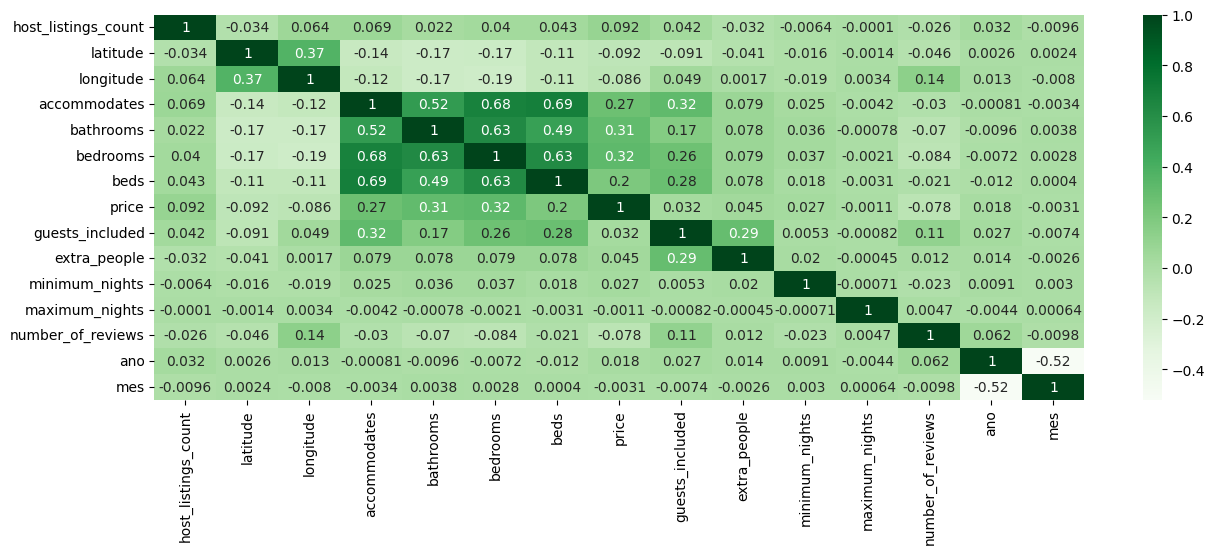

In [23]:
# fisualização da correlação com mapa de calor
plt.figure(figsize=(15, 5))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')

# print(base_airbnb.corr(numeric_only=True))

### Definição de funções para Analizar de Outliers

Vamos definir funções para ajudar na analize de outliers das colunas

In [99]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf , lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [131]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)
    
# def histograma(coluna):
#     sns.displot(coluna, kind='hist', kde=True, stat='density', bins=100, kde_kws=dict(cut=3, bw_adjust=3), height=5, aspect=3)
#     plt.title('Histograma com Gráfico de Densidade (cut=3, bw_adjust=30)', fontsize=16)
#     plt.xlabel('Valores', fontsize=12)
#     plt.xlim(-10, 1300)
#     plt.ylabel('Densidade', fontsize=12)
#     plt.ylim(0, 0.0050)  # Limitar o eixo Y para 0.00035
#     plt.show()

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### price

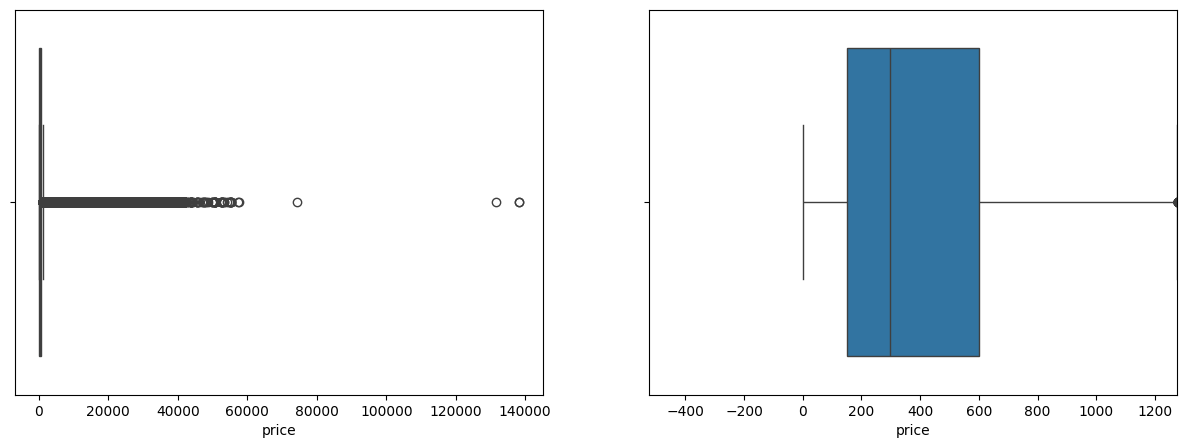

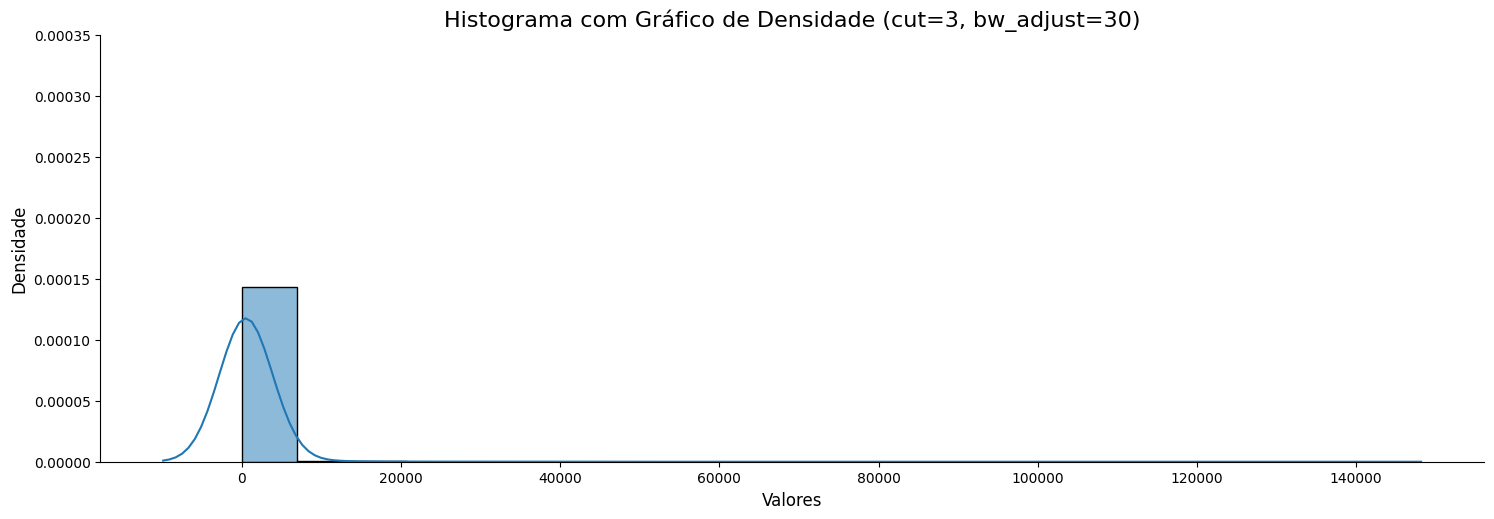

In [94]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [100]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'{linhas_removidas} linhas removidas')

87282 linhas removidas


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3183810161.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


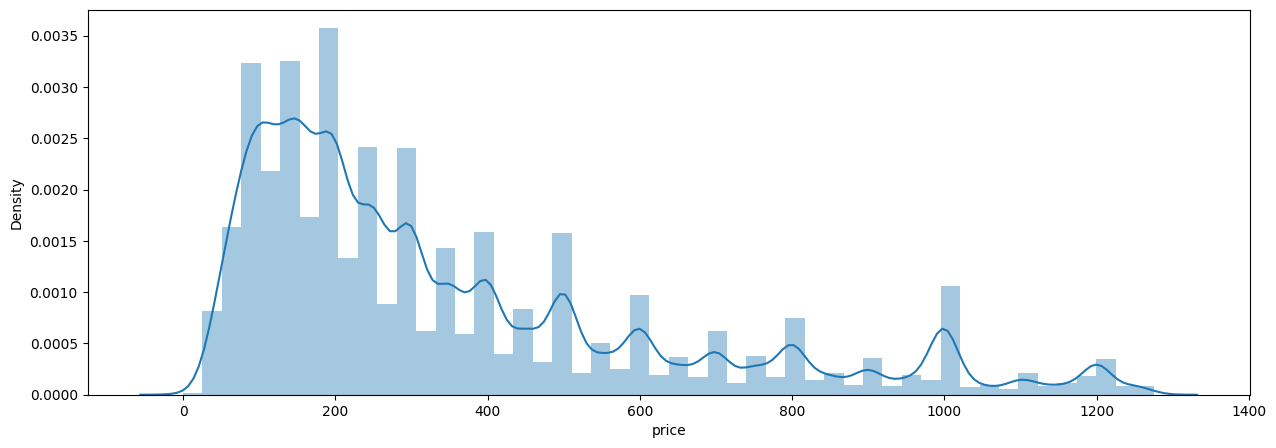

In [125]:
histograma(base_airbnb['price'])

### extra_people

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3183810161.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


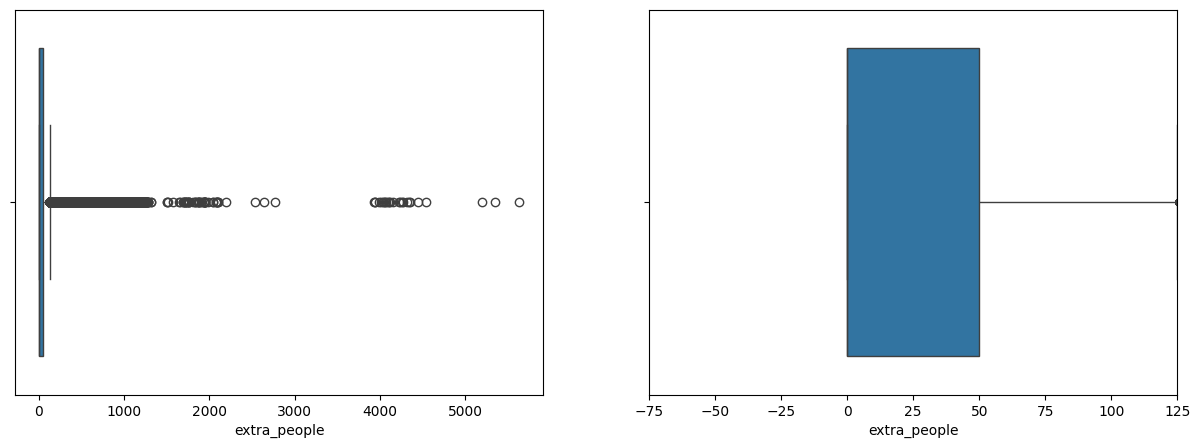

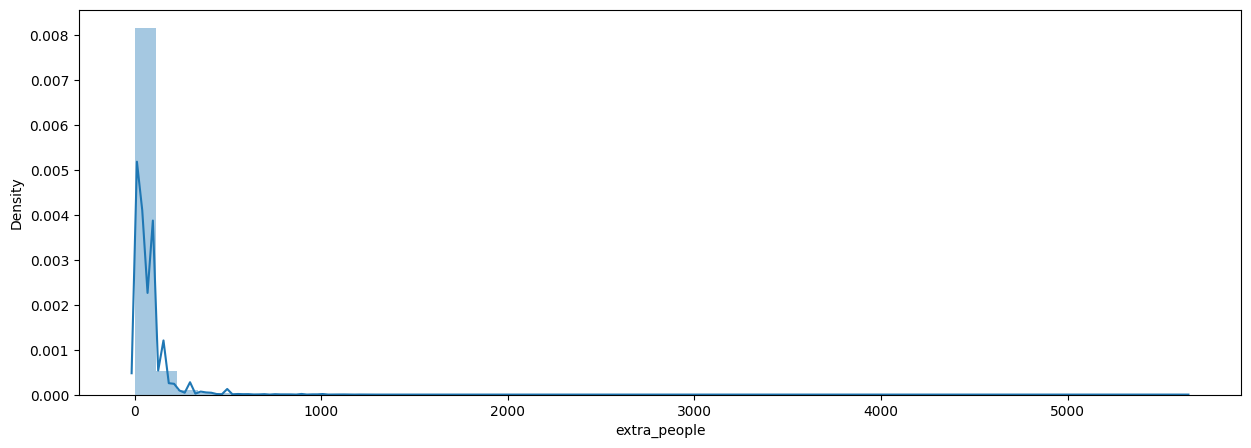

In [126]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [127]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{linhas_removidas} linhas removidas')

59194 linhas removidas


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15952\3183810161.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


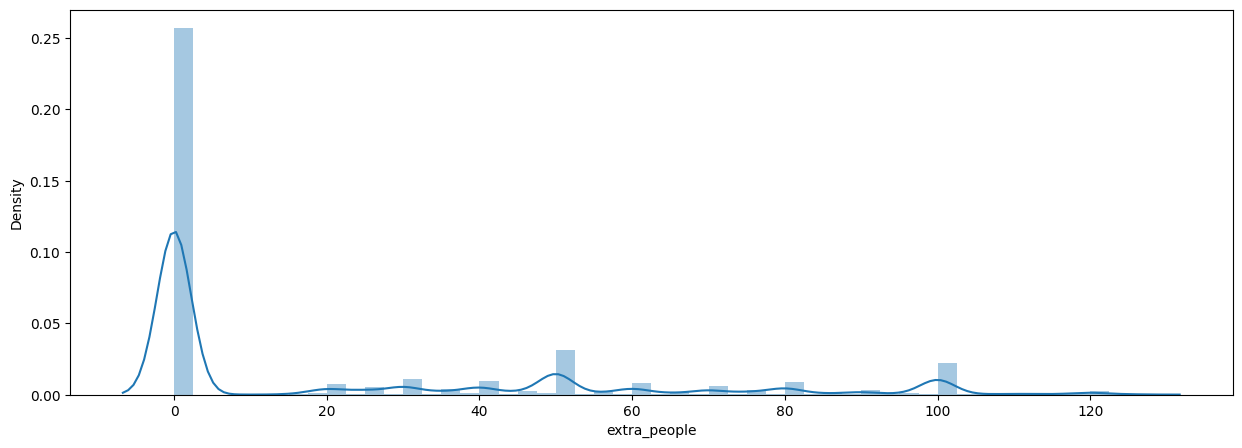

In [128]:
histograma(base_airbnb['extra_people'])

### host_listings_count  

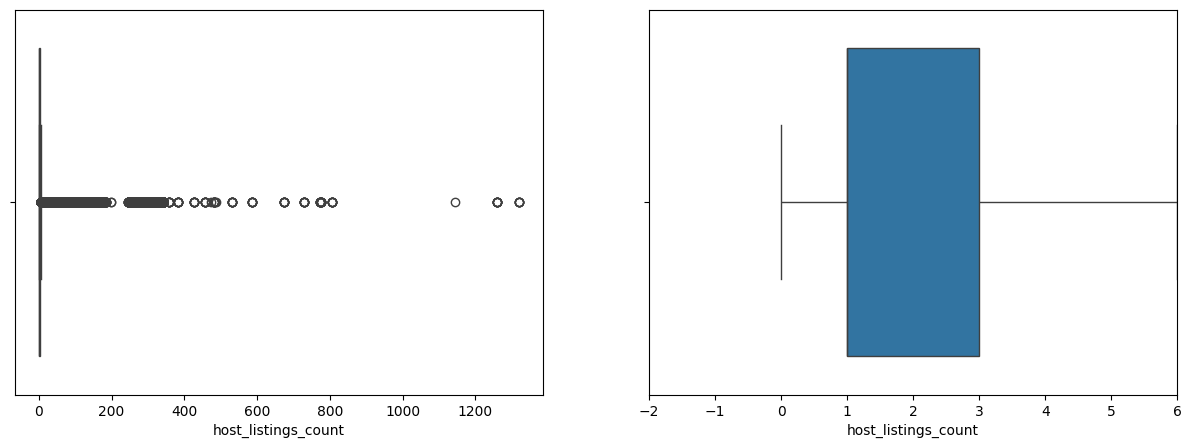

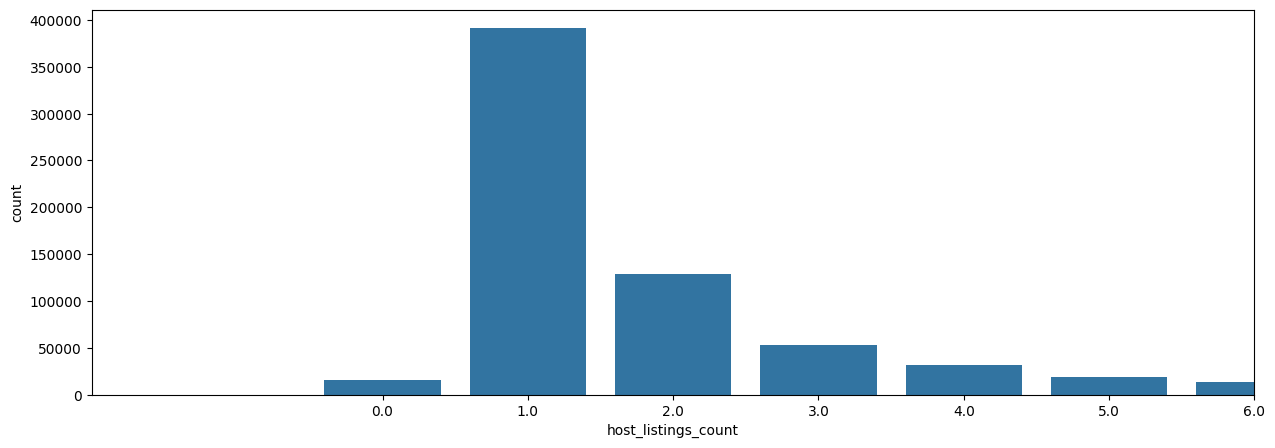

In [132]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [133]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas')

97723 linhas removidas


### accommodates

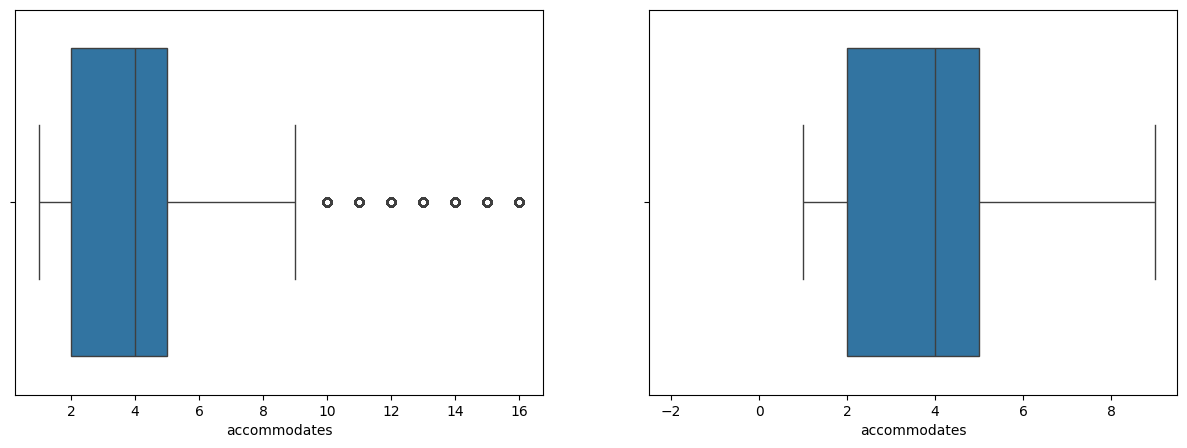

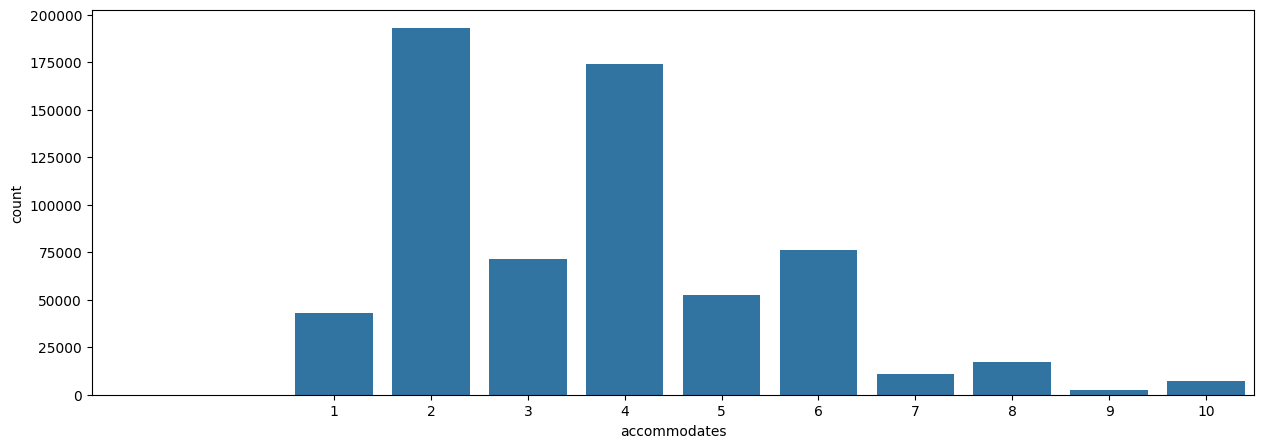

In [134]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [135]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{linhas_removidas} linhas removidas')

13146 linhas removidas


### bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

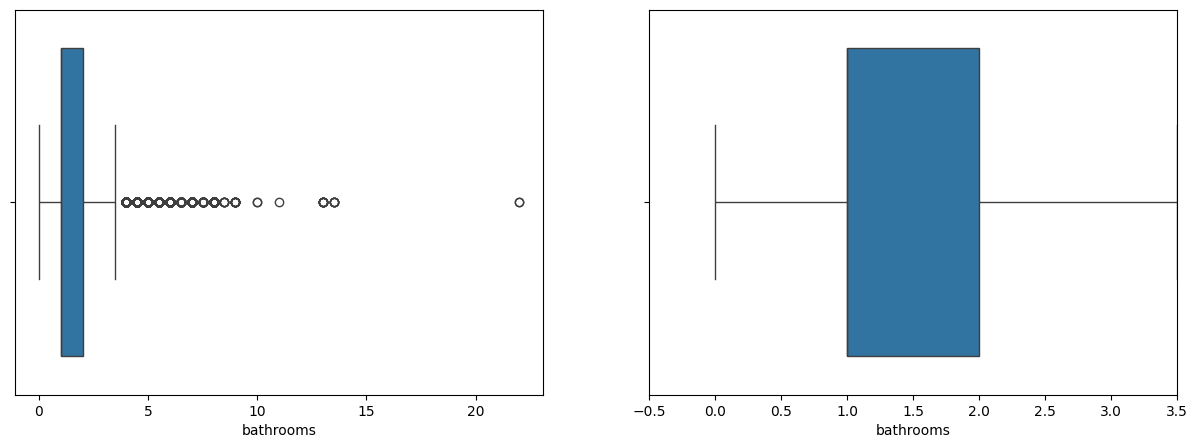

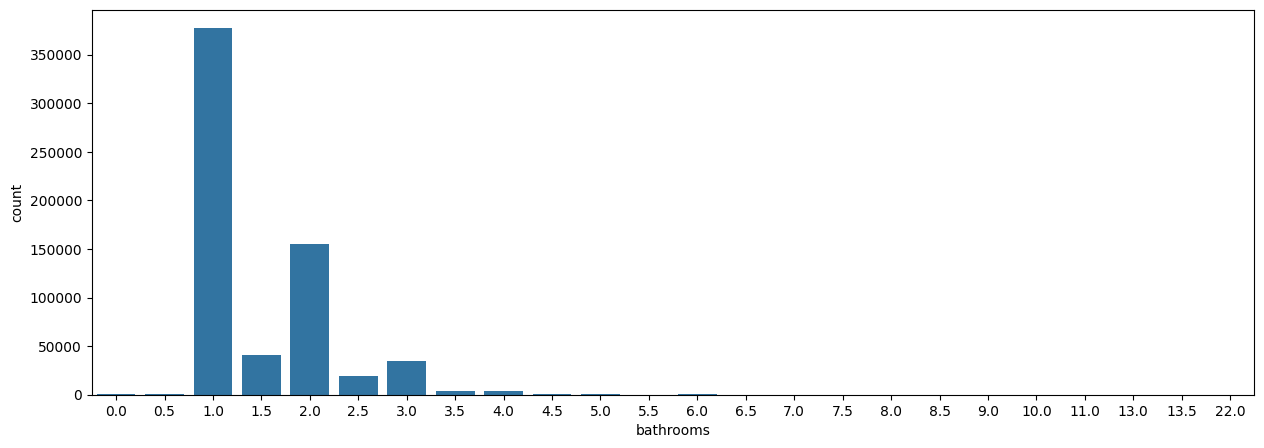

In [137]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [138]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas} linhas removidas')

6894 linhas removidas


       
                  
bathrooms                  
bedrooms                   
beds                       
guests_included               
minimum_nights               
maximum_nights                
number_of_reviews             



### Encoding

### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo